# Predicting return from Gold

1: Importing and Preparing Data(การกำหนดแนวทางรวบรวมและเตรียมข้อมูล)

2: การสร้างแบบจำลองการถดถอยโดยใช้ PyCaret

3: การจัดประเภทโมเดลโดยใช้ PyCaret

4: การสร้างแบบจำลองอนุกรมเวลาโดยใช้Prophet (Facebook)

5: การประเมินการบูรณาการแนวทาง 

### Background

ทองคำเป็นแหล่งเก็บมูลค่าดั้งเดิมและเป็นสื่อกลางในการแลกเปลี่ยนกับมนุษยชาติมานานหลายศตวรรษจนกระทั่งเงินตรากระดาษเข้ามาในช่วงสองสามศตวรรษที่ผ่านมา อย่างไรก็ตามสกุลเงินกระดาษที่ยั่งยืนส่วนใหญ่ได้รับการสนับสนุนโดย Gold จนถึงปลายปี 1971 เมื่อข้อตกลง Bretton Woods ถูกยกเลิกและสกุลเงินของโลกกลายเป็นสกุลเงิน ′𝐹𝑖𝑎𝑡′ ที่แท้จริง

อย่างไรก็ตามทองคำยังคงได้รับความสนใจไม่เพียง แต่เป็นโลหะที่เลือกใช้สำหรับเครื่องประดับเท่านั้น แต่ยังเป็นที่เก็บของมูลค่าและมักจะแนะนำให้เป็นส่วนหนึ่งของพอร์ตการลงทุนที่หลากหลายเนื่องจากมีแนวโน้มที่จะป้องกันเงินเฟ้อที่มีประสิทธิภาพและเป็นที่หลบภัยเมื่อเศรษฐกิจกำลังดำเนินไป

### Approach

การทำนายผลตอบแทนจากราคาทองคำโดยใช้แมชชีนเลิร์นนิง

อันดับแรกเราจะใช้เส้นทางการถดถอยเพื่อทำนายผลตอบแทนของทองคำในอนาคตในช่วง 2 และ 3 สัปดาห์ถัดไป จะทำสิ่งนี้โดยใช้ผลตอบแทนในอดีตของตราสารต่าง ๆ ซึ่งเชื่อว่ามีผลต่อแนวโน้มทองคำ เหตุผลพื้นฐานคือ ทองคำว่าเป็นสินทรัพย์'ปฏิกิริยาโต้ตอบ' มีปัจจัยพื้นฐานของตัวเองเพียงเล็กน้อยและการเคลื่อนไหวของราคามักเป็นอนุพันธ์ของการที่นักลงทุนมองสินทรัพย์ประเภทอื่น ๆ (ตราสารทุนสินค้าโภคภัณฑ์ ฯลฯ )

## Importing and Preparing Data

เราจะต้องมีราคาปิดของตราสารหลายรายการในช่วง 10 ปีที่ผ่านมา มีแหล่งข้อมูลที่ต้องชำระเงินมากมาย (Reuters, Bloomberg) และแหล่งข้อมูลฟรี (IEX, Quandl, Yahoofinance, Google finance) ที่สามารถใช้เพื่อนำเข้าข้อมูลได้ เนื่องจากโครงการนี้จำเป็นชนิดที่แตกต่างกันของสินทรัพย์ (หุ้นสินค้าโภคภัณฑ์หนี้และโลหะมีค่า) ผมพบว่า' yahoofinancials 'แพคเกจที่จะเป็นประโยชน์มากและตรงไปตรงมา

Note 

Python version 3.7

Pycaret version 2.0 (pip install --user pycaret==2.0)

Soybean Ticker is ZS=F(Ticker List.xlsx file)


In [1]:
#Importing Libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials 

เตรียมรายการเครื่องมือที่เราต้องการนำเข้าข้อมูล แพ็คเกจ yahoofinancials ต้องใช้สัญลักษณ์ของ Yahoo รายการนี้มีสัญลักษณ์และคำอธิบาย (ไฟล์ excel->Ticker List.xlsx) เรานำเข้าไฟล์นั้นและแยกสัญลักษณ์ ticker และชื่อรายการแยกต่างหาก

In [2]:
ticker_details = pd.read_excel('Ticker List.xlsx')
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()
print(ticker)
print(names)

['GC=F', 'SI=F', 'CL=F', '^GSPC', '^RUT', 'ZN=F', 'ZT=F', 'PL=F', 'HG=F', 'DX=F', '^VIX', 'ZS=F', 'EEM', 'EURUSD=X', '^N100', '^IXIC']
['Gold', 'Silver', 'Crude Oil', 'S&P500', 'Russel 2000 Index', '10 Yr US T-Note futures', '2 Yr US T-Note Futures', 'Platinum', 'Copper', 'Dollar Index', 'Volatility Index', 'Soybean', 'MSCI EM ETF', 'Euro USD', 'Euronext100', 'Nasdaq']


สร้างช่วงวันที่และเขียนลงใน dataframe ที่ว่างเปล่าที่มีชื่อว่า values ที่จะดึงและวางข้อมูลที่ดึงมาจาก yahoofinancials

แยกข้อมูลจาก Yahoo Finance และเพิ่มลงในตาราง Values โดยใช้วันที่เป็นkey

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= '2020-03-01'
start_date = '2010-01-01'
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

เมื่อมีช่วงวันที่ในดาต้าเฟรมแล้วเราจำเป็นต้องใช้สัญลักษณ์สัญลักษณ์เพื่อดึงข้อมูลจาก API yahoofinancials ส่งคืนผลลัพธ์ในรูปแบบ JSON รหัสต่อไปนี้วนอยู่เหนือรายการของสัญลักษณ์และแยกเฉพาะราคาปิดสำหรับวันที่ในอดีตทั้งหมดและเก็บเพิ่มลงในดาต้าเฟรมในแนวนอน หมายเหตุฉันได้ใช้ฟังก์ชันผสานเพื่อรักษาความศักดิ์สิทธิ์ของวันที่ เนื่องจากประเภทสินทรัพย์เหล่านี้อาจมีวันหยุดตามภูมิภาคและวันหยุดการซื้อขายที่แตกต่างกันช่วงวันที่จึงไม่ผูกมัดให้เหมือน โดยการรวมเข้าด้วยกันในที่สุดเราจะมี NA หลายตัว

In [5]:
print(values['Date'])

0      2010-01-01
1      2010-01-04
2      2010-01-05
3      2010-01-06
4      2010-01-07
          ...    
2646   2020-02-24
2647   2020-02-25
2648   2020-02-26
2649   2020-02-27
2650   2020-02-28
Name: Date, Length: 2651, dtype: datetime64[ns]


เมื่อมีช่วงวันที่ในดาต้าเฟรมแล้วเราจำเป็นต้องใช้สัญลักษณ์สัญลักษณ์เพื่อดึงข้อมูลจาก API yahoofinancials ส่งคืนผลลัพธ์ในรูปแบบ JSON รหัสต่อไปนี้วนอยู่เหนือรายการของสัญลักษณ์และแยกเฉพาะราคาปิดสำหรับวันที่ในอดีตทั้งหมดและเก็บเพิ่มลงในดาต้าเฟรมในแนวนอน หมายเหตุฉันได้ใช้ฟังก์ชันผสานเพื่อรักษาความศักดิ์สิทธิ์ของวันที่ เนื่องจากประเภทสินทรัพย์เหล่านี้อาจมีวันหยุดตามภูมิภาคและวันหยุดการซื้อขายที่แตกต่างกันช่วงวันที่จึงไม่ผูกมัดให้เหมือน โดยการรวมเข้าด้วยกันในที่สุดเราจะมี NA หลายตัว

แยกข้อมูลจาก Yahoo Finance และเพิ่มลงในตาราง valuesโดยใช้วันที่เป็น key

In [6]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, 'daily')
    #print(raw_data)
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    #print(df)
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)


เปลี่ยนชื่อคอลัมน์เพื่อแสดงชื่อเครื่องมือแทนที่จะเป็นสัญลักษณ์(Ticker) เพื่อความสะดวกในการอ่าน

In [7]:
#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(2651, 17)
Date                         0
Gold                       117
Silver                     117
Crude Oil                  116
S&P500                      95
Russel 2000 Index           95
10 Yr US T-Note futures    118
2 Yr US T-Note Futures     116
Platinum                   123
Copper                     117
Dollar Index               118
Volatility Index            95
Soybean                    116
MSCI EM ETF                 95
Euro USD                   327
Euronext100                 56
Nasdaq                      95
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.400024,18.868000,51.430000,3225.889893,1628.099976,132.656250,108.273438,971.700012,2.5925,99.283997,25.030001,874.25,41.005680,1.083905,1120.449951,9221.280273
2647,2020-02-25,1646.900024,18.183001,49.900002,3128.209961,1571.900024,133.125000,108.398438,929.799988,2.5965,98.901001,27.850000,879.00,40.680943,1.084920,1099.270020,8965.610352
2648,2020-02-26,1640.000000,17.826000,48.730000,3116.389893,1552.760010,133.328125,108.480469,912.299988,2.5765,98.938004,27.559999,881.00,41.005680,1.088200,1099.410034,8980.780273
2649,2020-02-27,1640.000000,17.658001,47.090000,2978.760010,1497.869995,133.437500,108.550781,903.599976,2.5715,98.460999,39.160000,886.25,40.021622,1.088589,1059.359985,8566.480469
2650,2020-02-28,1564.099976,16.386999,44.759998,2954.219971,1476.430054,134.843750,108.929688,862.799988,2.5460,98.081001,40.110001,883.50,39.874016,1.099723,1021.979980,8567.370117


In [8]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

บังคับให้ค่าในคอลัมน์เป็นตัวเลขทั้งหมด ยกเว้นDate

In [9]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=1)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2646,2020-02-24,1672.4,18.9,51.4,3225.9,1628.1,132.7,108.3,971.7,2.6,99.3,25.0,874.2,41.0,1.1,1120.4,9221.3
2647,2020-02-25,1646.9,18.2,49.9,3128.2,1571.9,133.1,108.4,929.8,2.6,98.9,27.9,879.0,40.7,1.1,1099.3,8965.6
2648,2020-02-26,1640.0,17.8,48.7,3116.4,1552.8,133.3,108.5,912.3,2.6,98.9,27.6,881.0,41.0,1.1,1099.4,8980.8
2649,2020-02-27,1640.0,17.7,47.1,2978.8,1497.9,133.4,108.6,903.6,2.6,98.5,39.2,886.2,40.0,1.1,1059.4,8566.5
2650,2020-02-28,1564.1,16.4,44.8,2954.2,1476.4,134.8,108.9,862.8,2.5,98.1,40.1,883.5,39.9,1.1,1022.0,8567.4


save ข้อมูลลงใน Training Data_Values.csv

In [10]:
values.to_csv("Training Data_Values.csv")

ในแนวทางข้างต้นเราเน้นว่าเราจะใช้ผลตอบแทนที่ล้าหลังของตราสารในรายการเพื่อทำนายผลตอบแทนของทองคำในอนาคต ที่นี่เราจะคำนวณผลตอบแทนในอดีตระยะสั้นของตราสารทั้งหมดและผลตอบแทนในอดีตระยะยาวของตราสารที่เลือกเพียงไม่กี่รายการ

แนวคิดพื้นฐานที่อยู่เบื้องหลังคือว่าหากสินทรัพย์บางรายการมีประสิทธิภาพสูงหรือต่ำกว่าประสิทธิภาพสูงมีโอกาสที่พอร์ตการลงทุนจะปรับสมดุลได้มากขึ้นซึ่งจะส่งผลกระทบต่อผลตอบแทนในสินทรัพย์ประเภทอื่น ๆ ในอนาคต เช่น: หากตลาดหุ้น (เช่น S & P500) แสดงผลตอบแทนที่น่าทึ่งในช่วง 6 เดือนที่ผ่านมาผู้จัดการสินทรัพย์อาจต้องการทำกำไรและจัดสรรเงินบางส่วนเพื่อบอกโลหะมีค่าและเตรียมพร้อมสำหรับการปรับฐานของตลาดหุ้น แผนภูมิด้านล่างแสดงให้เห็นว่าการเคลื่อนไหวของราคาและความสัมพันธ์ระหว่างทองคำและ S & P500 ในสภาวะตลาดที่แตกต่างกันอย่างไร อย่างไรก็ตามเราจะใช้ Machine Learning เพื่อประเมินสมมติฐาน

In [11]:
imp = ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
# Calculating Short term -Historical Returns
change_days = [1,3,5,14,21]

data = pd.DataFrame(data=values['Date'])
for i in change_days:
    print(data.shape)
    x= values[cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)
print()
# Calculating Long term Historical Returns
change_days = [60,90,180,250]

for i in change_days:
    print(data.shape)
    x= values[imp].pct_change(periods=i).add_suffix("-T-"+str(i))
    data=pd.concat(objs=(data,x),axis=1)
    x=[]
print(data.shape)

(2651, 1)
(2651, 17)
(2651, 33)
(2651, 49)
(2651, 65)
(2651, 81)

(2651, 81)
(2651, 86)
(2651, 91)
(2651, 96)
(2651, 101)


นอกจากผลตอบแทนที่ล้าหลังแล้วเรายังดูว่าราคาทองคำในปัจจุบันอยู่ห่างจากค่าเฉลี่ยเคลื่อนที่สำหรับหน้าต่างที่แตกต่างกันเพียงใด นี่คือเมตริกที่ใช้กันมากในการวิเคราะห์ทางเทคนิคโดยที่ค่าเฉลี่ยเคลื่อนที่เสนอการสนับสนุนและความต้านทานสำหรับราคาสินทรัพย์ เราใช้การผสมผสานระหว่างค่าเฉลี่ยเคลื่อนที่อย่างง่ายและเลขชี้กำลัง จากนั้นเราจะเพิ่มค่าเฉลี่ยเคลื่อนที่เหล่านี้ลงในพื้นที่คุณลักษณะที่มีอยู่

การคำนวณค่า Movig average

In [12]:
#Calculating Moving averages for Gold
moving_avg = pd.DataFrame(values['Date'],columns=['Date'])
moving_avg['Date']=pd.to_datetime(moving_avg['Date'],format='%Y-%b-%d')
moving_avg['Gold/15SMA'] = (values['Gold']/(values['Gold'].rolling(window=15).mean()))-1
moving_avg['Gold/30SMA'] = (values['Gold']/(values['Gold'].rolling(window=30).mean()))-1
moving_avg['Gold/60SMA'] = (values['Gold']/(values['Gold'].rolling(window=60).mean()))-1
moving_avg['Gold/90SMA'] = (values['Gold']/(values['Gold'].rolling(window=90).mean()))-1
moving_avg['Gold/180SMA'] = (values['Gold']/(values['Gold'].rolling(window=180).mean()))-1
moving_avg['Gold/90EMA'] = (values['Gold']/(values['Gold'].ewm(span=90,adjust=True,ignore_na=True).mean()))-1
moving_avg['Gold/180EMA'] = (values['Gold']/(values['Gold'].ewm(span=180,adjust=True,ignore_na=True).mean()))-1
moving_avg = moving_avg.dropna(axis=0)
print(moving_avg.shape)
moving_avg.head()

(2472, 8)


,Date,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA
179,2010-09-09,0.005005,0.020246,0.026862,0.026428,0.067496,0.032506,0.046162
180,2010-09-10,0.000536,0.014916,0.023422,0.022489,0.063095,0.028204,0.041912
181,2010-09-13,0.000043,0.013705,0.023840,0.022565,0.062965,0.028040,0.041852
182,2010-09-14,0.017736,0.031368,0.043642,0.042295,0.083187,0.047219,0.061593
183,2010-09-15,0.013857,0.026901,0.040711,0.039604,0.079958,0.043701,0.058291


การรวมค่า Moving Average เข้ากับ feature space

In [13]:
#Merging Moving Average values to the feature space
print(data.shape)
data['Date']=pd.to_datetime(data['Date'],format='%Y-%b-%d')
data = pd.merge(left=data,right=moving_avg,how='left',on='Date')
print(data.shape)
data.isna().sum()

(2651, 101)
(2651, 108)


Date               0
Gold-T-1           1
Silver-T-1         1
Crude Oil-T-1      1
S&P500-T-1         1
                ... 
Gold/60SMA       179
Gold/90SMA       179
Gold/180SMA      179
Gold/90EMA       179
Gold/180EMA      179
Length: 108, dtype: int64

กำแพงนี้เกี่ยวกับคุณสมบัติ ตอนนี้เราต้องสร้างเป้าหมายนั่นคือสิ่งที่เราต้องการทำนาย เนื่องจากเรากำลังคาดการณ์ผลตอบแทนเราจึงต้องเลือกขอบฟ้าที่เราต้องการทำนายผลตอบแทน ฉันเลือกขอบเขต 14 วันและ 22 วันเนื่องจากขอบเขตที่เล็กกว่าอื่น ๆ มักจะผันผวนมากและขาดและมีอำนาจในการทำนาย อย่างไรก็ตามเราสามารถทดลองกับขอบเขตอื่น ๆ ได้เช่นกัน

การคำนวณผลตอบแทนล่วงหน้าสำหรับเป้าหมาย

In [14]:
#Caluculating forward returns for Target
y = pd.DataFrame(data=values['Date'])
print(y.shape)
#y['Gold-T+1']=values["Gold"].pct_change(periods=-1)
y['Gold-T+14']=values["Gold"].pct_change(periods=-14)
y['Gold-T+22']=values["Gold"].pct_change(periods=-22)
print(y.shape)
y.isna().sum()

(2651, 1)
(2651, 3)


Date          0
Gold-T+14    14
Gold-T+22    22
dtype: int64

การลบ NAs(Missing value)

In [15]:
# Removing NAs
data = data[data['Gold-T-250'].notna()]
y = y[y['Gold-T+22'].notna()]
#เช็คจำนวน Gold-T-250วัน ว่าไม่มีข้อมูลที่เป็นNAsเท่าไหร่
print(data.shape)
print(y.shape)

เช็คจำนวน Gold-T-250วัน ว่าไม่มีข้อมูลที่เป็นNAsเท่าไหร่ (2401, 108)
(2629, 3)


ตอนนี้เราจะรวมตัวแปร Target เข้ากับ feature space เพื่อรับข้อมูลที่เราสามารถเริ่มสร้างแบบจำลองได้ในที่สุด

การเพิ่มตัวแปรเป้าหมาย

In [16]:
#Adding Target Variables
data = pd.merge(left=data,right=y,how='inner',on='Date',suffixes=(False,False))
print(data.shape)
data.isna().sum()

(2379, 110)


Date             0
Gold-T-1         0
Silver-T-1       0
Crude Oil-T-1    0
S&P500-T-1       0
                ..
Gold/180SMA      0
Gold/90EMA       0
Gold/180EMA      0
Gold-T+14        0
Gold-T+22        0
Length: 110, dtype: int64

save เป็น Training Data.csv

In [17]:
data.to_csv("Training Data.csv",index=False)

In [18]:
corr = data.corr().iloc[:,-2:].drop(labels=['Gold-T+14','Gold-T+22'],axis=0)

In [19]:
corr

,Gold-T+14,Gold-T+22
Gold-T-1,0.006177,0.018110
Silver-T-1,-0.015534,0.007442
Crude Oil-T-1,0.011693,0.028162
S&P500-T-1,0.012515,0.022498
Russel 2000 Index-T-1,0.016176,0.027082
...,...,...
Gold/60SMA,0.064204,0.078562
Gold/90SMA,0.072479,0.088899
Gold/180SMA,0.036749,0.040567
Gold/90EMA,0.061684,0.074235


In [20]:
import seaborn as sns
import numpy as np

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Gold-T+14', ylabel='Density'>

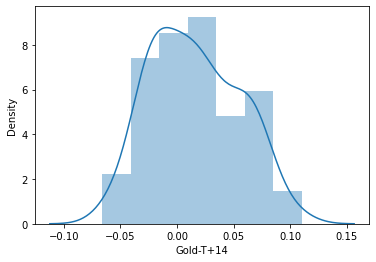

In [21]:
sns.distplot(corr.iloc[:,0])

In [22]:
pd.set_option('display.max_rows', None)
corr_data = data.tail(2000).corr()
corr_data = pd.DataFrame(corr_data['Gold-T+14'])
#corr_data = corr_data.iloc[3:,]
corr_data = corr_data.sort_values('Gold-T+14',ascending=False)
#corr_data

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

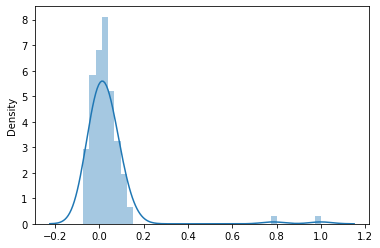

In [23]:
sns.distplot(corr_data)

# Regression

## 22 Day Model

In [24]:
#data = pd.read_csv("Training Data.csv")

In [25]:
from pycaret.regression import *

In [26]:
data_22= data.drop(['Gold-T+14'],axis=1)
data_22.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+22
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.093842,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.007675
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.087977,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.011166
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.095930,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.030969
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.098837,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.034154
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.105263,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,0.026404


In [27]:
a=setup(data_22,target='Gold-T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=False);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed.


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


ชื่อmodelทั้งหมดที่สามารถใช้ในการทำนาย(ในregression)

In [28]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


sklearn.metrics เพื่อช่วยประเมินค่าความถูกต้องของผลลัพท์

Metrics  โมเดลประเภท Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE 

MAE ย่อมาจาก “Mean Absolute Error” คำนวณง่ายๆแค่หาผลรวมของค่า absolute(error) แล้วคูณกับ 1/n เพื่อเปลี่ยนเป็นค่าเฉลี่ย

MSE ย่อมาจาก “Mean Squared Error” จะคล้ายกับ MAE แค่เปลี่ยนจากการทำ absolute เป็น squared (ยกกำลังสองค่า error) ก่อนหาค่าเฉลี่ย

RMSE ย่อมาจาก “Root Mean Square Error” ทำ square root ค่า MSE เพื่อให้ได้ค่า loss ที่มีหน่วยเดียวกับตัวแปร y เหตุผลที่ต้องทำ SQRT เพราะว่าเรายกกำลังสองค่า error ก่อนหาค่าเฉลี่ยทำให้หน่วยมันเปลี่ยนไปจากเดิม(ถ้า RMSE เท่ากับ 2.56 แปลว่าโดยเฉลี่ยโมเดลทำนาย y ผิดไป +/- 2.56 point)

MAPE ย่อมาจาก “Mean Absolute Percentage Error” มีลักษณะคล้าย MAE แต่เปลี่ยนค่าเป็น percent

RMSLE(root mean squared log error) คือ root mean squared error (RMSE) ของ target variable ที่ take log แล้ว

R2 คือ variance ที่โมเดลของเราอธิบายได้เป็นสัดส่วนจาก total variance ทั้งหมดของข้อมูลชุดนั้น (นักสถิติใช้สูตรคำนวณ total variance = explained variance + error) โดย **R2 จะมีค่าอยู่ระหว่าง 0-1 ยิ่งเข้าใกล้ 1 แปลว่าโมเดลเราทำนายผลได้ดีมาก

**MAE,MSE,MAPE, RMSE มีค่ายิ่งต่ำยิ่งดี ถ้าเท่ากับ 0 แปลว่าโมเดลทำนายค่า y ได้ถูกต้องเป๊ะ 100% ในทางปฏิบัติโอกาสที่จะเทรนโมเดลได้ loss = 0 เป็นไปได้ยากมาก เพราะอาจนำไปสู่ปัญหา Overfitting ได้


ref. 
https://medium.com/@615162020027/metrics-พื้นฐานสำหรับวัดประสิทธิภาพของโมเดล-machine-learning-c00fcc32fa30
https://medium.com/@witchapongdaroontham/เจาะลึก-random-forest-part-2-of-รู้จัก-decision-tree-random-forest-และ-xgboost-79b9f41a1c1c
https://datarockie.com/2019/03/30/top-ten-machine-learning-metrics/

ref. https://medium.com/c-g-datacommunity/pycaret-ผู้ช่วยยุคใหม่ที่จะทำให้การเลือกใช้-machine-learning-ง่ายขึ้น-462ddf4364b

tr = TheilSen Regressor
Theil-Sen estimator ใช้การลากเส้นตรงระหว่างจุดสองจุดที่สุ่มขึ้นมา พอได้เส้นตรงเยอะๆ แล้วค่อยหาค่าเฉลี่ยของเส้นพวกนั้น ข้อดีของวิธีนี้ คือ คำนวณได้ค่อนข้างเร็ว แต่มีเงื่อนไขว่าหากข้อมูลมีการกระจายมาก ผลลัพท์ที่ได้จะมี error สูง

ref. https://www.bluebirz.net/th/2264/note-of-data-science-training-ep-4/

In [29]:
tr = create_model('tr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0290,0.0014,0.0370,0.1839,0.0287,0.0004
1,0.0308,0.0018,0.0425,-0.2511,0.0265,-2.1669
2,0.0303,0.0018,0.0419,0.2170,0.0319,0.4041
3,0.0308,0.0017,0.0418,0.0770,0.0302,-0.5992
4,0.0281,0.0015,0.0381,0.2136,0.0282,0.1840
5,0.0314,0.0016,0.0400,0.1977,0.0324,-1.0306
6,0.0346,0.0020,0.0448,0.1455,0.0348,1.7746
7,0.0325,0.0020,0.0445,0.2371,0.0368,-0.1693
8,0.0321,0.0018,0.0424,-0.0423,0.0298,0.6993
9,0.0313,0.0016,0.0399,0.0718,0.0294,-0.3223


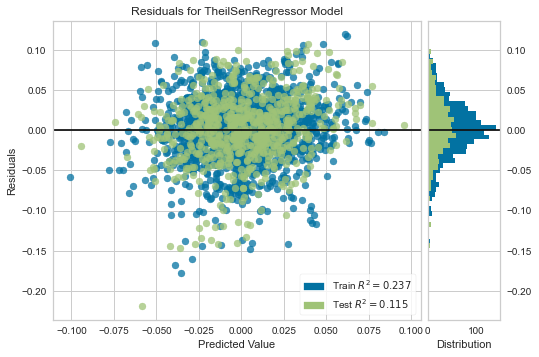

In [30]:
plot_model(tr)

In [31]:
ard = create_model('ard')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0286,0.0013,0.0366,0.2012,0.0295,0.0947
1,0.0274,0.0013,0.0364,0.0838,0.0271,-1.8711
2,0.0304,0.0017,0.0409,0.2547,0.0356,0.1868
3,0.0302,0.0016,0.0399,0.1559,0.0302,-0.6246
4,0.0286,0.0014,0.0381,0.2141,0.0304,0.2345
5,0.0300,0.0015,0.0393,0.2234,0.0321,-0.7297
6,0.0338,0.0019,0.0440,0.1738,0.0356,1.5350
7,0.0324,0.0019,0.0439,0.2590,0.0364,-0.1962
8,0.0298,0.0015,0.0390,0.1152,0.0303,0.7929
9,0.0290,0.0014,0.0372,0.1937,0.0308,-0.4407


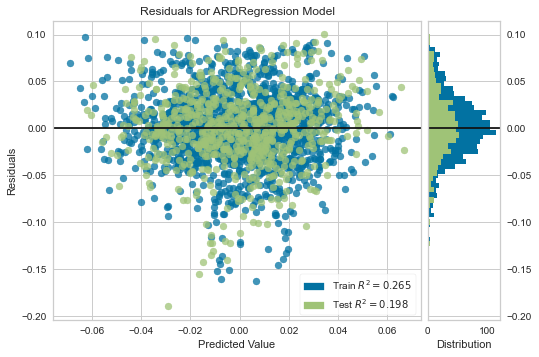

In [32]:
plot_model(ard)

In [33]:
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0145,0.0004,0.0196,0.7704,0.0159,0.4986
1,0.0112,0.0002,0.0148,0.8479,0.0130,-0.8262
2,0.0139,0.0004,0.0205,0.8123,0.0170,-0.2190
3,0.0138,0.0004,0.0194,0.8015,0.0159,0.3063
4,0.0116,0.0002,0.0149,0.8801,0.0132,0.3527
5,0.0137,0.0003,0.0182,0.8343,0.0161,-0.8846
6,0.0137,0.0003,0.0182,0.8590,0.0159,0.1472
7,0.0155,0.0005,0.0217,0.8187,0.0184,0.1047
8,0.0124,0.0003,0.0175,0.8216,0.0147,0.4950
9,0.0121,0.0003,0.0171,0.8291,0.0144,-0.3015


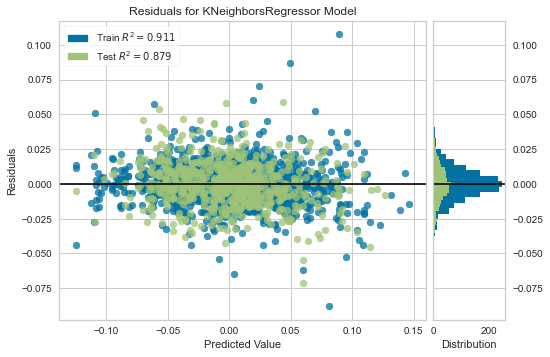

In [34]:
plot_model(knn)

In [35]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0130,0.0003,0.0176,0.8154,0.0165,0.1759
1,0.0104,0.0002,0.0139,0.8653,0.0127,-0.4533
2,0.0133,0.0003,0.0182,0.8533,0.0163,-0.1426
3,0.0130,0.0003,0.0170,0.8468,0.0157,0.3504
4,0.0107,0.0002,0.0144,0.8872,0.0135,0.0188
5,0.0121,0.0003,0.0162,0.8683,0.0148,-0.4067
6,0.0129,0.0003,0.0183,0.8575,0.0161,0.1034
7,0.0150,0.0004,0.0202,0.8424,0.0183,0.0044
8,0.0118,0.0003,0.0161,0.8493,0.0148,0.3003
9,0.0112,0.0002,0.0149,0.8701,0.0137,-0.4294


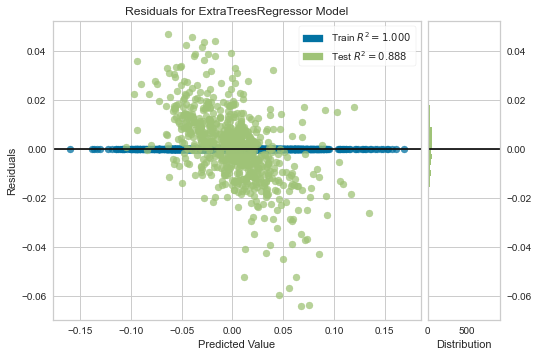

In [36]:
plot_model(et)

In [37]:
#compare_models(blacklist=['tr','ard'],turbo=True)
compare_models(['tr','ard'],turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,0.0124,0.0003,0.0167,0.8556,0.0152,-0.0479,1.6874
1,CatBoost Regressor,0.0132,0.0003,0.0175,0.8410,0.0159,-0.0546,27.1378
2,K Neighbors Regressor,0.0132,0.0003,0.0182,0.8275,0.0155,-0.0327,0.0412
3,Light Gradient Boosting Machine,0.0138,0.0003,0.0183,0.8268,0.0164,-0.1669,0.8458
4,Random Forest,0.0154,0.0004,0.0208,0.7748,0.0189,-0.1178,4.3180
5,Extreme Gradient Boosting,0.0157,0.0004,0.0211,0.7703,0.0185,-0.1391,1.7819
6,Gradient Boosting Regressor,0.0202,0.0007,0.0263,0.6412,0.0239,-0.0023,4.1294
7,Decision Tree,0.0220,0.0011,0.0335,0.4129,0.0231,0.1097,0.1746
8,AdaBoost Regressor,0.0299,0.0014,0.0374,0.2702,0.0336,0.1813,1.5217
9,Bayesian Ridge,0.0302,0.0016,0.0399,0.1722,0.0331,-0.1489,0.0509


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

tune_model() คือการนำโมเดลมาปรับค่าไฮเปอร์พารามิเตอร์เพื่อให้ได้ผลลัพธ์ที่ดียิ่งขึ้น

In [38]:
#knn_tuned = tune_model('knn',n_iter=150)
knn_tuned = tune_model(knn,n_iter=150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0109,0.0002,0.0151,0.8646,0.0126,0.8397
1,0.0108,0.0002,0.0146,0.8521,0.0131,-1.3066
2,0.0126,0.0004,0.0193,0.8336,0.0158,-0.1494
3,0.0109,0.0003,0.0177,0.8344,0.0132,-0.2879
4,0.0095,0.0002,0.0123,0.9180,0.0112,0.1777
5,0.0108,0.0003,0.0161,0.8700,0.0143,-0.6400
6,0.0113,0.0002,0.0155,0.8980,0.0140,0.1330
7,0.0129,0.0004,0.0200,0.8459,0.0164,0.1451
8,0.0102,0.0002,0.0143,0.8805,0.0123,1.1556
9,0.0092,0.0002,0.0130,0.9017,0.0116,-0.5973


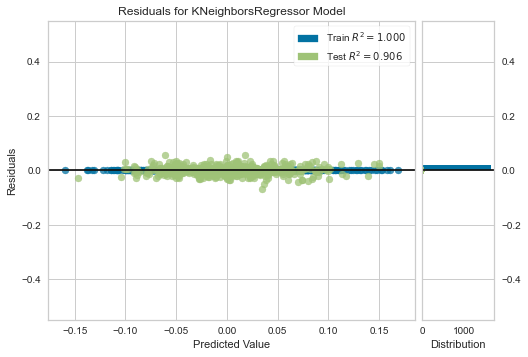

In [39]:
plot_model(knn_tuned)

In [40]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0127,0.0003,0.0166,0.8366,0.0155,0.2158
1,0.0112,0.0002,0.0153,0.8384,0.0137,-0.6891
2,0.0145,0.0004,0.0196,0.8291,0.0176,-0.4286
3,0.0138,0.0003,0.0183,0.8235,0.0169,0.4034
4,0.0119,0.0003,0.0159,0.8628,0.0146,0.0120
5,0.0125,0.0003,0.0163,0.8669,0.0148,-0.6946
6,0.0135,0.0004,0.0188,0.8487,0.0165,0.1325
7,0.0161,0.0005,0.0214,0.8235,0.0198,0.0588
8,0.0133,0.0003,0.0177,0.8172,0.0163,0.8270
9,0.0120,0.0002,0.0153,0.8635,0.0139,-0.3835


In [43]:
catb_tuned = tune_model(catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0132,0.0003,0.0172,0.8229,0.0159,0.4502
1,0.0119,0.0002,0.0155,0.8343,0.0136,-1.1287
2,0.0150,0.0004,0.0205,0.8123,0.0185,-0.2822
3,0.0152,0.0004,0.0197,0.7950,0.0181,0.8301
4,0.0129,0.0003,0.0174,0.8362,0.0158,0.2736
5,0.0130,0.0003,0.0169,0.8573,0.0155,-0.3624
6,0.0141,0.0004,0.0187,0.8509,0.0163,0.4971
7,0.0165,0.0005,0.0230,0.7963,0.0210,0.0870
8,0.0133,0.0003,0.0175,0.8212,0.0159,0.5679
9,0.0130,0.0003,0.0168,0.8357,0.0148,-0.6627


In [45]:
et_tuned = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0155,0.0004,0.0211,0.7336,0.0196,0.1564
1,0.0129,0.0003,0.0177,0.7818,0.0164,-0.2653
2,0.0164,0.0005,0.0223,0.7791,0.0202,-0.1358
3,0.0157,0.0004,0.0209,0.7685,0.0194,1.4797
4,0.0129,0.0003,0.0180,0.8238,0.0169,0.0114
5,0.0151,0.0004,0.0210,0.7783,0.0195,-0.3210
6,0.0153,0.0004,0.0212,0.8085,0.0194,0.2041
7,0.0188,0.0006,0.0252,0.7546,0.0226,0.0155
8,0.0148,0.0004,0.0205,0.7561,0.0188,0.5400
9,0.0136,0.0003,0.0184,0.8028,0.0169,-0.4952


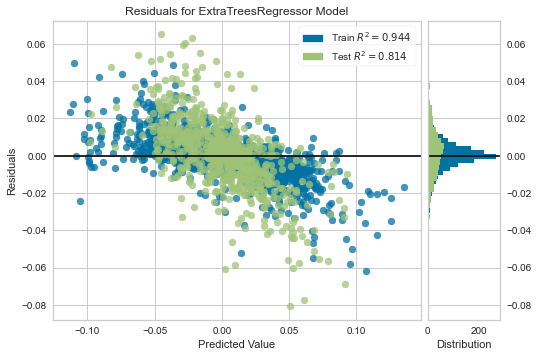

In [46]:
plot_model(et_tuned)

In [47]:
evaluate_model(knn_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [48]:
evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

bจะลบค่าผิดปกติ remove_outliers=True (a ไม่ได้ลบ)

In [49]:
b=setup(data_22,target='Gold-T+22',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed.


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [50]:
knn = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0142,0.0003,0.0184,0.8124,0.0163,-0.0552
1,0.0126,0.0003,0.0165,0.8666,0.0141,-0.5348
2,0.0130,0.0003,0.0170,0.8587,0.0150,0.3886
3,0.0116,0.0003,0.0161,0.8709,0.0147,-0.3921
4,0.0131,0.0003,0.0162,0.8460,0.0148,-0.1459
5,0.0147,0.0004,0.0201,0.8271,0.0171,0.9604
6,0.0130,0.0003,0.0178,0.7931,0.0151,0.2255
7,0.0127,0.0003,0.0184,0.8372,0.0149,-0.7770
8,0.0125,0.0003,0.0166,0.8628,0.0152,0.3036
9,0.0128,0.0003,0.0182,0.8123,0.0158,0.2121


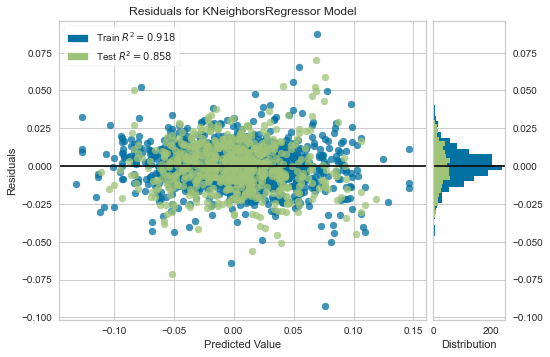

In [51]:
plot_model(knn)

In [52]:
knn_tuned = tune_model(knn,n_iter=150)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0096,0.0002,0.0123,0.9162,0.0112,-0.0008
1,0.0099,0.0002,0.0134,0.9130,0.0116,-0.4380
2,0.0118,0.0003,0.0176,0.8474,0.0148,1.6197
3,0.0104,0.0003,0.0158,0.8746,0.0146,-0.5064
4,0.0108,0.0002,0.0150,0.8685,0.0135,0.0392
5,0.0109,0.0002,0.0153,0.8996,0.0129,1.5222
6,0.0104,0.0002,0.0150,0.8531,0.0132,0.2973
7,0.0104,0.0002,0.0150,0.8926,0.0128,-0.1093
8,0.0109,0.0002,0.0148,0.8913,0.0135,0.2829
9,0.0107,0.0002,0.0157,0.8606,0.0135,-0.2443


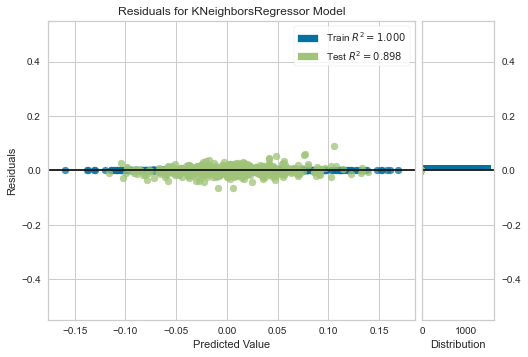

In [53]:
plot_model(knn_tuned)

In [54]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0121,0.0003,0.0163,0.8526,0.0154,-0.0752
1,0.0122,0.0003,0.0162,0.8717,0.0151,-0.2421
2,0.0121,0.0003,0.0165,0.8671,0.0154,0.5698
3,0.0117,0.0003,0.0164,0.8651,0.0153,-0.4476
4,0.0113,0.0002,0.0154,0.8623,0.0144,-0.1627
5,0.0138,0.0004,0.0193,0.8406,0.0178,0.9692
6,0.0107,0.0002,0.0145,0.8624,0.0135,0.4297
7,0.0119,0.0003,0.0162,0.8747,0.0144,-0.5581
8,0.0123,0.0003,0.0164,0.8668,0.0152,0.2384
9,0.0109,0.0002,0.0144,0.8830,0.0132,-0.6744


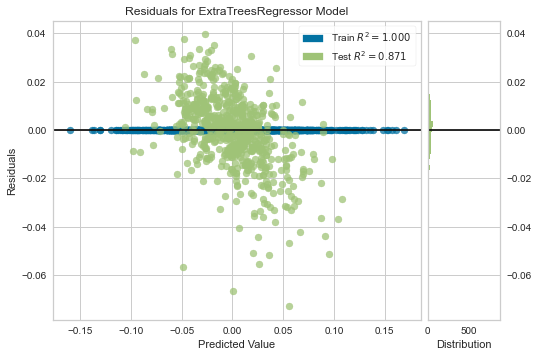

In [55]:
plot_model(et)

In [56]:
catb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0124,0.0003,0.0160,0.8579,0.0148,0.0861
1,0.0127,0.0003,0.0170,0.8594,0.0155,-0.6813
2,0.0129,0.0003,0.0173,0.8537,0.0162,1.2032
3,0.0124,0.0003,0.0175,0.8472,0.0161,-0.3474
4,0.0125,0.0003,0.0166,0.8399,0.0152,-0.2263
5,0.0148,0.0004,0.0204,0.8221,0.0187,1.2782
6,0.0121,0.0003,0.0160,0.8320,0.0144,0.6707
7,0.0128,0.0003,0.0177,0.8503,0.0155,-0.4786
8,0.0133,0.0003,0.0175,0.8492,0.0160,0.2908
9,0.0117,0.0002,0.0149,0.8743,0.0136,-0.8747


### Ensembling Models

Ensemble Method คือหนึ่งในเทคนิคของ Machine learning ที่นำ Model หลายๆ Model มารวมกันเพื่อที่จะทำให้ผลลัพธ์ออกมาดีที่สุด 
ref.
https://medium.com/botnoi-classroom/botnoi-classroom-มาทำให้ผลลัพธ์ดีขึ้นด้วย-ensemble-method-กันเถอะ-b5ac9acfa8d3


method='Bagging'  -> Bagging (bootstrap aggregation) คือการสุ่มข้อมูลมาจากข้อมูลประชากร เพื่อใช้คำนวณค่าทางสถิติของประชากรกลุ่มเล็กๆที่เราสุ่มออกมา หรือ การสุ่มตัวอย่างข้อมูลออกมาแล้วสร้าง classifier ขึ้นมา สำหรับวิธีการสุ่มข้อมูลออกมา เราใช้วิธีสุ่มแบบแทนที่ (random with replacement) ซึ่งหมายความว่าข้อมูลที่เรามียังอยู่เหมือนเดิม ไม่ได้ลดลงหลังจากการสุ่ม 

ref. 
https://tupleblog.github.io/bagging-boosting/
https://medium.com/cw-quantlab/ensemble-learning-method-98359636adf9

In [60]:
et_bagged = ensemble_model(et,method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0151,0.0004,0.0198,0.7823,0.0186,-0.0687
1,0.0158,0.0004,0.0203,0.7996,0.0190,-0.1560
2,0.0156,0.0004,0.0211,0.7813,0.0199,1.0862
3,0.0151,0.0005,0.0214,0.7717,0.0200,-0.3908
4,0.0141,0.0004,0.0189,0.7908,0.0177,-0.1245
5,0.0171,0.0006,0.0236,0.7615,0.0219,0.8928
6,0.0134,0.0003,0.0183,0.7812,0.0171,0.1051
7,0.0160,0.0005,0.0215,0.7780,0.0195,-0.7186
8,0.0154,0.0004,0.0209,0.7840,0.0196,0.2202
9,0.0142,0.0003,0.0184,0.8087,0.0171,-0.4827


In [61]:
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0101,0.0002,0.0127,0.9102,0.0117,0.0555
1,0.0097,0.0002,0.0127,0.9212,0.0109,-0.2502
2,0.0113,0.0003,0.0159,0.8765,0.0133,1.0827
3,0.0103,0.0002,0.0142,0.8995,0.0129,-0.4973
4,0.0107,0.0002,0.0142,0.8828,0.0127,0.0337
5,0.0120,0.0003,0.0165,0.8834,0.0143,1.3027
6,0.0109,0.0002,0.0148,0.8557,0.0131,0.4448
7,0.0104,0.0003,0.0161,0.8763,0.0138,-0.4299
8,0.0111,0.0002,0.0146,0.8949,0.0137,0.3271
9,0.0113,0.0003,0.0170,0.8370,0.0141,1.0914


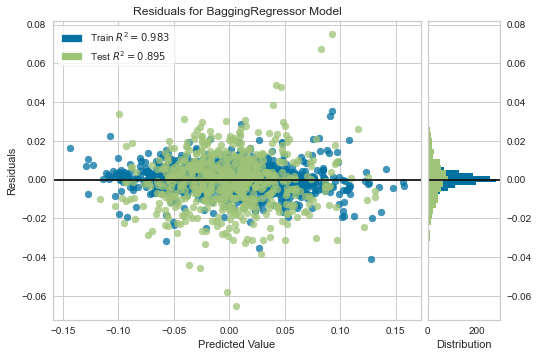

In [62]:
plot_model(knn_tuned_bagged)

In [64]:
evaluate_model(knn_tuned_bagged)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Blending Models

blend_models() แนวคิดคือการรวมMLที่แตกต่างกันและใช้การโหวตเสียงข้างมาก(majority vote)หรือความน่าจะเป็นโดยเฉลี่ยที่คาดการณ์ไว้ในกรณีของการจำแนกประเภทเพื่อทำนายผลลัพธ์สุดท้าย
ref.
https://pycaret.org/blend-models/

In [65]:
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0094,0.0001,0.0122,0.9170,0.0115,-0.0586
1,0.0098,0.0002,0.0129,0.9187,0.0116,-0.2564
2,0.0103,0.0002,0.0147,0.8943,0.0132,0.5092
3,0.0099,0.0002,0.0144,0.8966,0.0133,-0.4267
4,0.0098,0.0002,0.0130,0.9006,0.0119,-0.1062
5,0.0110,0.0002,0.0156,0.8956,0.0138,1.2262
6,0.0097,0.0002,0.0130,0.8886,0.0119,0.2616
7,0.0098,0.0002,0.0139,0.9078,0.0121,-0.4004
8,0.0102,0.0002,0.0138,0.9064,0.0128,0.2728
9,0.0097,0.0002,0.0137,0.8945,0.0120,-0.2057


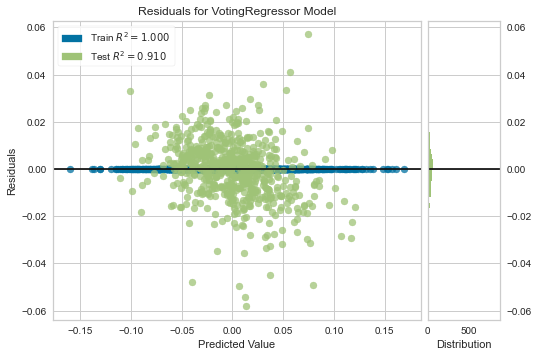

In [66]:
plot_model(blend_knn_et)

In [68]:
evaluate_model(blend_knn_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

WARNING : create_stacknet function will be deprecated in future release of PyCaret 2.x.

create_stacknet(estimator_list= [[],[]])-> Multiple Layer Stacking() การวางซ้อนโมเดลหลายๆโมเดล 
ref. https://pycaret.org/stack-models/

In [69]:
stack1 = create_stacknet(estimator_list=[[catb,knn_tuned],[et,blend_knn_et]],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0088,0.0001,0.0116,0.9260,0.0103,0.1129
1,0.0096,0.0002,0.0129,0.9191,0.0116,-0.8774
2,0.0112,0.0003,0.0158,0.8772,0.0139,0.5321
3,0.0107,0.0002,0.0151,0.8856,0.0140,-0.7142
4,0.0102,0.0002,0.0139,0.8878,0.0126,-0.2094
5,0.0106,0.0002,0.0146,0.9094,0.0133,1.1723
6,0.0100,0.0002,0.0132,0.8866,0.0118,0.4704
7,0.0101,0.0002,0.0143,0.9015,0.0126,-0.2826
8,0.0104,0.0002,0.0143,0.8993,0.0128,0.3522
9,0.0093,0.0002,0.0126,0.9096,0.0112,-0.5295


In [74]:
stack2 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0089,0.0001,0.0118,0.9234,0.0109,-0.0306
1,0.0091,0.0001,0.0120,0.9294,0.0109,-0.6902
2,0.0100,0.0002,0.0140,0.9038,0.0128,0.4045
3,0.0102,0.0002,0.0143,0.8978,0.0133,-0.7235
4,0.0098,0.0002,0.0133,0.8967,0.0122,-0.2537
5,0.0105,0.0002,0.0147,0.9074,0.0132,1.0128
6,0.0092,0.0001,0.0121,0.9047,0.0109,0.3288
7,0.0093,0.0002,0.0135,0.9128,0.0121,-0.4048
8,0.0094,0.0002,0.0133,0.9122,0.0122,0.2921
9,0.0092,0.0001,0.0120,0.9179,0.0107,-0.6426


In [77]:
stack3 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True,meta_model=blend_knn_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0087,0.0001,0.0112,0.9309,0.0105,-0.0908
1,0.0090,0.0001,0.0121,0.9280,0.0105,-0.4437
2,0.0105,0.0002,0.0150,0.8902,0.0132,0.7666
3,0.0098,0.0002,0.0148,0.8902,0.0138,-0.4581
4,0.0098,0.0002,0.0135,0.8933,0.0122,-0.1131
5,0.0098,0.0002,0.0134,0.9231,0.0119,1.3410
6,0.0095,0.0002,0.0131,0.8872,0.0118,0.3404
7,0.0100,0.0002,0.0143,0.9015,0.0125,-0.4329
8,0.0096,0.0002,0.0127,0.9198,0.0119,0.2878
9,0.0093,0.0002,0.0132,0.9011,0.0116,-0.3318


save model stack2 เพราะค่าที่ได้เปรียบเทียบกันแล้ว ดีกว่าmodelอื่นๆ(เฉพาะกับการทำนายล่วงหน้า22วัน)

In [78]:
save_model(model=stack2, model_name='22Day Regressor')

Transformation Pipeline and Model Succesfully Saved


### 14 Day Model 

ทำคล้ายกับการ 22Day Regressor แต่เปลี่ยนเป็นการทำนายล่วงหน้า14วัน

In [79]:
data_14= data.drop(['Gold-T+22'],axis=1)
data_14.head()

,Date,Gold-T-1,Silver-T-1,Crude Oil-T-1,S&P500-T-1,Russel 2000 Index-T-1,10 Yr US T-Note futures-T-1,2 Yr US T-Note Futures-T-1,Platinum-T-1,Copper-T-1,...,S&P500-T-250,MSCI EM ETF-T-250,Gold/15SMA,Gold/30SMA,Gold/60SMA,Gold/90SMA,Gold/180SMA,Gold/90EMA,Gold/180EMA,Gold-T+14
0,2010-12-17,0.005984,0.010417,0.003421,0.000805,0.003734,0.008306,0.000913,0.001415,0.02439,...,0.097882,0.093842,-0.008206,-0.001805,0.012638,0.040506,0.092005,0.035494,0.070472,0.005250
1,2010-12-20,0.005005,0.006873,0.009091,0.002573,0.003592,-0.000824,0.000000,0.007183,0.00000,...,0.100706,0.087977,-0.004174,0.003610,0.016601,0.044304,0.096390,0.039744,0.074871,0.012422
2,2010-12-21,0.001949,0.003413,0.011261,0.006014,0.010482,-0.000824,-0.000912,0.006547,0.02381,...,0.103916,0.095930,-0.002386,0.006090,0.017567,0.044925,0.097391,0.040811,0.075992,0.010555
3,2010-12-22,-0.001009,0.000000,0.007795,0.003348,0.000127,-0.009901,0.000000,0.005227,0.00000,...,0.107027,0.098837,-0.003368,0.005374,0.015569,0.042501,0.095189,0.038850,0.073962,0.002023
4,2010-12-23,-0.004903,-0.003401,0.011050,-0.001589,-0.002024,-0.003333,0.000000,-0.004506,0.00000,...,0.100815,0.105263,-0.007851,0.001003,0.009699,0.036124,0.088766,0.032987,0.067834,-0.004113


In [80]:
c=setup(data_14,target='Gold-T+14',
        ignore_features=['Date'],session_id=11,
        silent=True,profile=False,remove_outliers=True);
        #transformation=True,
        #pca=True,pca_method='kernel',
        #pca_components=10,
        #create_clusters=True,
        #cluster_iter=10,
        #feature_ratio=True,
        #normalize=True,
        #transform_target=True,
       #silent=True);

 
Setup Succesfully Completed.


,Description,Value
0,session_id,11
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2379, 109)"
4,Missing Values,False
5,Numeric Features,107
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [81]:
#compare_models(blacklist=['tr','ard'],turbo=True)
compare_models(['tr','ard'],turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extra Trees Regressor,0.0116,0.0002,0.0157,0.8043,0.0146,-0.0002,1.7223
1,CatBoost Regressor,0.0121,0.0003,0.0165,0.7843,0.0151,-0.0450,28.3049
2,K Neighbors Regressor,0.0124,0.0003,0.0172,0.7617,0.0147,-0.1333,0.0461
3,Light Gradient Boosting Machine,0.0130,0.0003,0.0176,0.7519,0.0156,0.1088,0.9067
4,Random Forest,0.0144,0.0004,0.0196,0.6929,0.0178,-0.0535,4.6152
5,Extreme Gradient Boosting,0.0145,0.0004,0.0202,0.6777,0.0173,-0.0925,1.7657
6,Gradient Boosting Regressor,0.0177,0.0005,0.0233,0.5690,0.0209,-0.0921,3.9094
7,Decision Tree,0.0193,0.0009,0.0295,0.2935,0.0211,-0.2565,0.1967
8,AdaBoost Regressor,0.0241,0.0009,0.0305,0.2606,0.0279,0.0311,1.4248
9,Bayesian Ridge,0.0251,0.0011,0.0336,0.1076,0.0280,-0.0269,0.0703


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=11, verbose=0, warm_start=False)

In [82]:
knn_tuned = tune_model(knn,n_iter=150)
catb = create_model('catboost')
et = create_model('et')
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0097,0.0002,0.0124,0.8763,0.0114,-0.0916
1,0.0097,0.0002,0.0133,0.8750,0.0122,0.0083
2,0.0091,0.0001,0.0119,0.9000,0.0113,-0.2328
3,0.0094,0.0002,0.0133,0.8569,0.0109,0.1278
4,0.0096,0.0002,0.0124,0.8575,0.0112,-1.7925
5,0.0109,0.0002,0.0151,0.8489,0.0134,-0.1722
6,0.0098,0.0002,0.0127,0.8421,0.0116,0.0260
7,0.0089,0.0001,0.0120,0.8846,0.0111,-0.5002
8,0.0088,0.0001,0.0116,0.8823,0.0105,0.2358
9,0.0098,0.0002,0.0139,0.8591,0.0125,-0.0574


In [83]:
stack1 = create_stacknet(estimator_list=[[catb,knn_tuned],[et,blend_knn_et]],restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0093,0.0001,0.0121,0.8838,0.0109,-0.1648
1,0.0091,0.0002,0.0125,0.8886,0.0113,-0.1329
2,0.0087,0.0001,0.0112,0.9120,0.0105,-0.1144
3,0.0087,0.0002,0.0127,0.8696,0.0093,0.2479
4,0.0094,0.0001,0.0121,0.8645,0.0108,-1.9997
5,0.0109,0.0002,0.0158,0.8362,0.0139,-0.1128
6,0.0091,0.0001,0.0120,0.8587,0.0109,0.0449
7,0.0088,0.0001,0.0120,0.8848,0.0111,-0.2942
8,0.0093,0.0002,0.0131,0.8510,0.0114,0.1627
9,0.0097,0.0002,0.0131,0.8752,0.0116,-0.1677


In [84]:
stack2 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0089,0.0001,0.0117,0.8905,0.0106,-0.0978
1,0.0088,0.0001,0.0121,0.8960,0.0109,-0.1036
2,0.0083,0.0001,0.0104,0.9234,0.0098,0.0325
3,0.0086,0.0002,0.0126,0.8702,0.0095,0.2157
4,0.0092,0.0001,0.0117,0.8732,0.0106,-1.3675
5,0.0107,0.0002,0.0151,0.8490,0.0131,-0.1279
6,0.0086,0.0001,0.0113,0.8747,0.0102,-0.0156
7,0.0085,0.0001,0.0116,0.8937,0.0106,-0.2320
8,0.0087,0.0002,0.0124,0.8660,0.0109,0.1634
9,0.0091,0.0002,0.0125,0.8855,0.0113,-0.0283


In [85]:
stack3 = create_stacknet(estimator_list=[[catb,et,knn_tuned],[blend_knn_et]], restack=True,meta_model=blend_knn_et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0088,0.0001,0.0112,0.8989,0.0101,-0.2580
1,0.0088,0.0001,0.0120,0.8974,0.0111,0.0369
2,0.0085,0.0001,0.0113,0.9098,0.0107,-0.3871
3,0.0089,0.0002,0.0128,0.8671,0.0096,0.1529
4,0.0091,0.0001,0.0121,0.8644,0.0107,-2.4493
5,0.0105,0.0002,0.0146,0.8588,0.0129,-0.2412
6,0.0090,0.0001,0.0121,0.8562,0.0108,0.1134
7,0.0081,0.0001,0.0112,0.9007,0.0104,-0.5942
8,0.0090,0.0002,0.0127,0.8601,0.0112,0.2795
9,0.0092,0.0002,0.0133,0.8713,0.0117,-0.0530


In [86]:
save_model(model=stack2, model_name='14Day Regressor')

Transformation Pipeline and Model Succesfully Saved
